In [1]:
import sqlite3
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.cluster import KMeans
import matplotlib
import operator
%matplotlib inline
import os
os.chdir('..')
from utilities.analysis import create_average_deck
os.chdir('notebooks/')

In [2]:
conn = sqlite3.connect('../netrunnerdb.db')
card_data = pd.read_sql('SELECT * FROM cards;', conn)
pe_card = card_data.loc[(card_data['title'].str.startswith('Jinteki: Personal Evolution')), 'code'].values[0]
decklist_data = pd.read_sql('SELECT * FROM decklist WHERE card_id = "%s";' % (pe_card,), conn)
decklist_data = decklist_data['deck_id']
decklist_data.drop_duplicates(inplace=True)
decklist_data = pd.DataFrame(decklist_data)
deck_data = pd.read_sql('SELECT * FROM decks;', conn)
deck_data = deck_data.merge(decklist_data, how='right', left_on='deck_id', right_on='deck_id')
deck_data.head()

,id,deck_id,name,username,description,created_at
0,20,709,Jintikering,Rakshasa,I have very little in the way of idea of how t...,2013-12-02 10:08:23
1,25,707,Clone Profits,CodeMarvelous,,2013-12-02 08:51:13
2,31,741,PE Tag & Bag,rupertpupkin9,<p>Nice steady drip damage from single point a...,2013-12-03 23:47:50
3,57,771,Iceless Shell Game v1.0,Ajar,<p>A Corp deck with no ice and no Hedge Fund? ...,2013-12-04 20:46:33
4,100,793,Jinteki Invasion,HepatitvsJ,<p>A rich jinteki deck with IoP for major disr...,2013-12-05 12:45:58


In [3]:
print(deck_data['username'].value_counts().head(5))
print(deck_data['created_at'].describe())

Diegofsv         15
CodeMarvelous    14
x3r0h0ur         10
travisrchance     8
Wolf88            8
Name: username, dtype: int64
count                     872
unique                    872
top       2015-06-26 15:22:24
freq                        1
Name: created_at, dtype: object


In [4]:
deck_data['created_at_dt'] = deck_data['created_at'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
deck_data['created_at_dt_date'] = deck_data['created_at_dt'].apply(lambda x: x.date())
deck_data['created_at_dt_date'].value_counts().head(10)

2014-04-29    7
2015-08-29    6
2016-01-22    6
2013-12-09    6
2015-01-09    6
2015-04-14    5
2014-04-28    5
2014-02-17    5
2015-04-03    5
2014-01-13    5
Name: created_at_dt_date, dtype: int64

In [5]:
decklists = pd.read_sql('SELECT * FROM decklist;', conn)
decklists = decklists.merge(card_data, how='left', left_on='card_id', right_on='code')
decklists = decklists[['deck_id', 'title', 'quantity_x']]
cards_with_name = decklists.merge(decklist_data, how='right', left_on='deck_id', right_on='deck_id')
cards_with_name = cards_with_name.loc[(cards_with_name['title'] != 'Jinteki: Personal Evolution')]
df = cards_with_name.copy()
df = df.groupby(['deck_id', 'title'])['quantity_x'].max().unstack()
df.fillna(0, inplace=True)
df_normalized = df.copy()
df_normalized = df_normalized.apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)))
df_normalized.head()

title,24/7 News Cycle,Accelerated Diagnostics,Adonis Campaign,Aggressive Negotiation,Aggressive Secretary,Akitaro Watanabe,Alix T4LB07,Allele Repression,Amazon Industrial Zone,An Offer You Can't Refuse,...,Wall of Thorns,Wendigo,Whirlpool,Will-o'-the-Wisp,Woodcutter,Wormhole,Wotan,Wraparound,Yagura,Zaibatsu Loyalty
deck_id,,,,,,,,,,,,,,,,,,,,,
10010,0,0,0,0,0,0,0,0,0,0,...,0.000000,0,0,0,0,0,0,0,0.000000,0
10033,0,0,0,0,0,0,0,0,0,0,...,0.000000,0,0,0,0,0,0,0,0.666667,0
10035,0,0,0,0,0,0,0,0,0,0,...,0.000000,0,0,0,0,0,0,0,0.000000,0
10148,0,0,0,0,0,0,0,0,0,0,...,0.000000,0,0,0,0,0,0,0,1.000000,0
10159,0,0,0,0,0,0,0,0,0,0,...,0.333333,0,0,0,0,0,0,0,0.000000,0


(-30.0, 40.0, -30.0, 30.0)

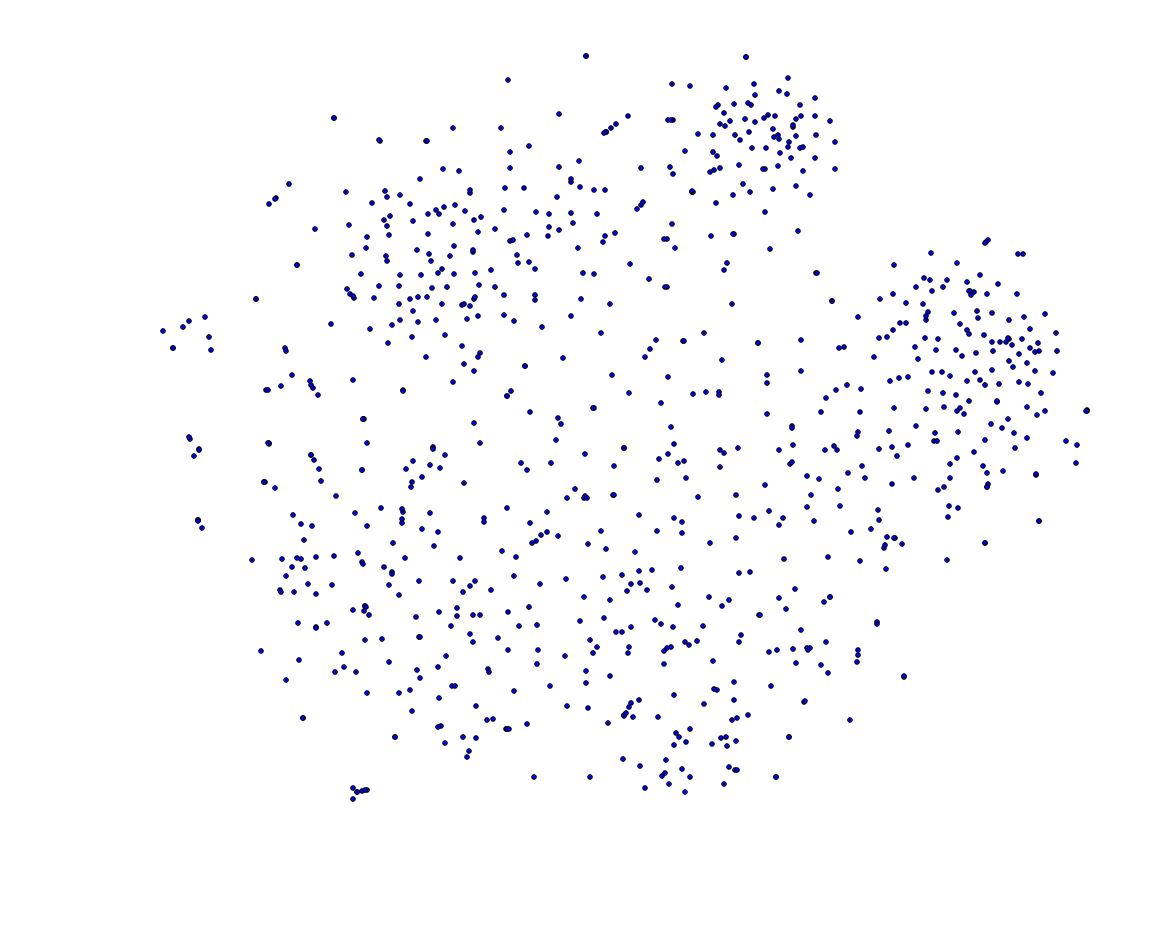

In [6]:
model = TSNE(n_components=2)
transformed = pd.DataFrame(model.fit_transform(df_normalized), columns=['X', 'Y'])
transformed.plot(kind='scatter', 
                 x='X', y='Y',
                figsize=(20,16))
matplotlib.pyplot.axis('off')

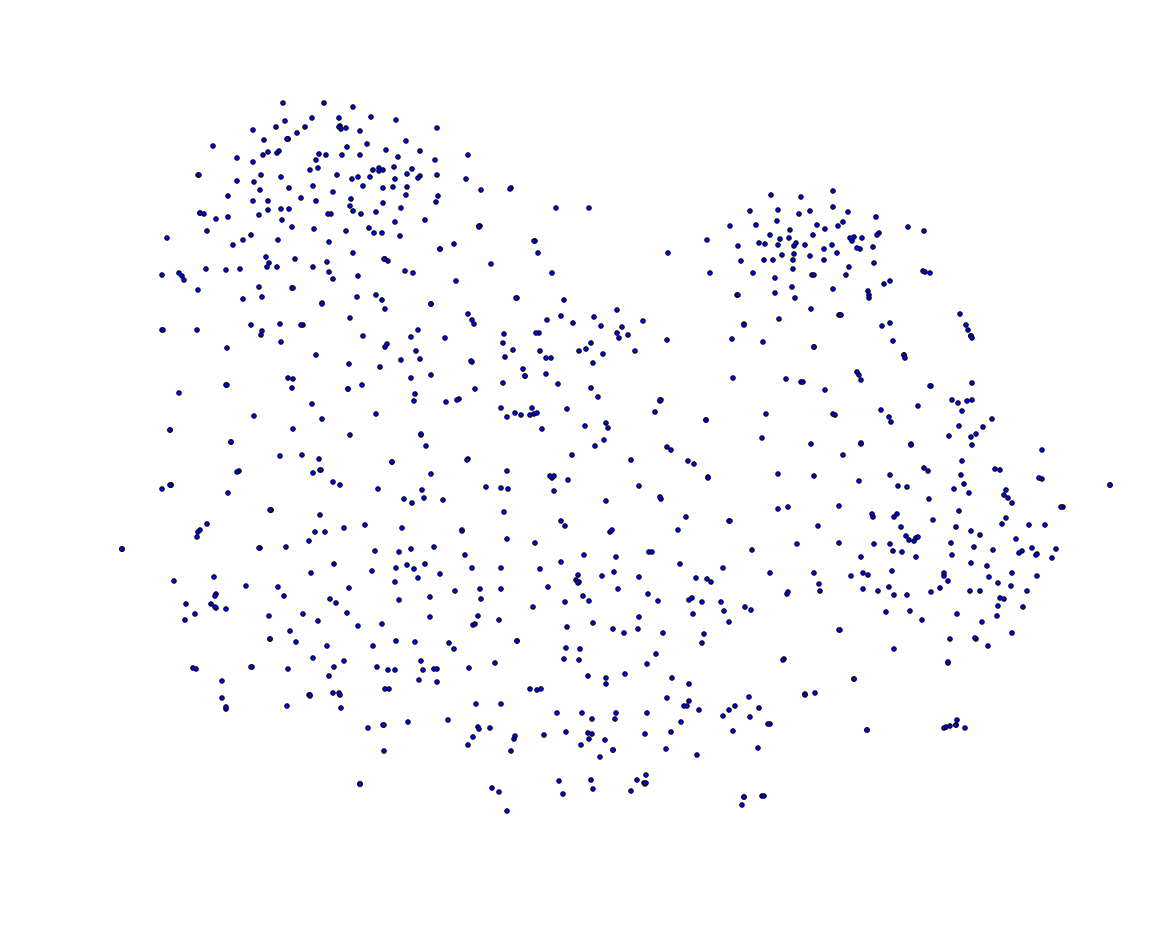

In [14]:
model = TSNE(n_components=2)
transformed = pd.DataFrame(model.fit_transform(df_normalized), columns=['X', 'Y'])
transformed.plot(kind='scatter', 
                 x='X', y='Y',
                figsize=(20,16))
matplotlib.pyplot.axis('off')
tfidftran = TfidfTransformer()
def_values = tfidftran.fit_transform(df_normalized)
kmeans = KMeans(n_clusters=5)
kmeans.fit(def_values.toarray())
transformed = transformed.join(pd.DataFrame(kmeans.labels_, columns=['grouping']))
transformed['X'].min()
transformed['Y'].min()
transformed['X'] = transformed['X'] + 25
transformed['Y'] = transformed['Y'] + 25

(-10.0, 60.0, -10.0, 70.0)

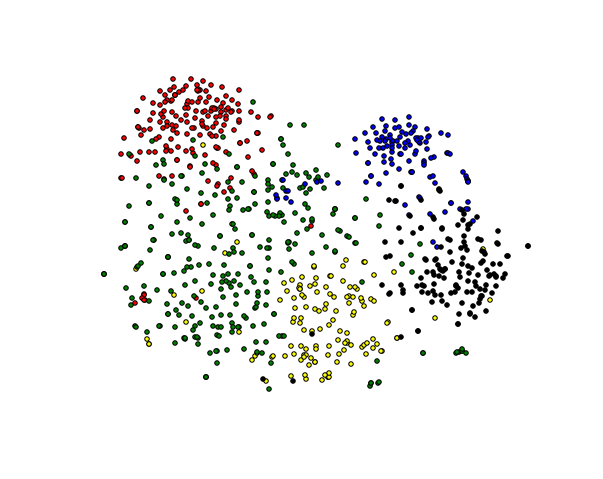

In [15]:
colors = ['red', 'yellow',
         'green', 'blue', 'black']

zipped = zip(transformed['grouping'].unique(), colors)

matplotlib.pyplot.figure(figsize=(10,8))

for groups, colors in zipped:
    matplotlib.pylab.scatter(transformed.loc[(transformed['grouping'] == groups), 'X'], 
                             transformed.loc[(transformed['grouping'] == groups), 'Y'],
                            c=colors, 
                            )
matplotlib.pyplot.axis('off')

In [16]:
df_clustering = df.copy()
df_clustering['index'] = [x for x in range(0, len(df_clustering))]
df_clustering = df_clustering.set_index('index')
df_clustering = df_clustering.join(pd.DataFrame(kmeans.labels_, columns=['grouping']))

transformed
df_deckids = df.copy()
df_deckids['index'] = [x for x in range(0, len(df_clustering))]
df_deckids = pd.DataFrame(df_deckids['index'])
df_deckids = df_deckids.merge(transformed, how='inner', left_on='index', right_index=True)
df_deckids

decks_to_send = deck_data.copy()
decks_to_send = decks_to_send.merge(df_deckids, how='inner', left_on='deck_id', right_index=True)

decks_to_send = decks_to_send[['X', 'Y', 'deck_id', 'grouping', 'name', 'created_at']]
decks_to_send
decks_to_send.to_json('../../netrunner_website/data/pe-deck.json', orient='index')

In [18]:
groupone = df_clustering.copy()
groupone = groupone.loc[(groupone['grouping'] == 1)]
cards = list(groupone.columns)
cards = [card for card in cards if card != 'grouping']
average_card_usage = {}
for card in cards:
    average = groupone[card].describe()['mean']
    if average > 0.0:
        average_card_usage[card] = average
        
sorted_dict = sorted(average_card_usage.items(), key=operator.itemgetter(1), reverse=True)
sorted_dict

[('Hedge Fund', 2.819672131147541),
 ('Snare!', 2.778688524590164),
 ('Neural Katana', 2.5491803278688523),
 ('Nisei MK II', 2.4836065573770494),
 ('Project Junebug', 2.418032786885246),
 ('PAD Campaign', 2.0327868852459017),
 ('Enigma', 2.0163934426229506),
 ('Priority Requisition', 2.0),
 ('Private Security Force', 1.8934426229508197),
 ('Chum', 1.778688524590164),
 ('Wall of Thorns', 1.721311475409836),
 ('Wall of Static', 1.6721311475409837),
 ('Neural EMP', 1.5491803278688525),
 ('Data Mine', 1.4918032786885247),
 ('Melange Mining Corp.', 1.2131147540983607),
 ('Beanstalk Royalties', 1.1557377049180328),
 ('Fetal AI', 1.0245901639344261),
 ('Precognition', 0.72950819672131151),
 ('Adonis Campaign', 0.68032786885245899),
 ('Braintrust', 0.63934426229508201),
 ('Tollbooth', 0.49180327868852458),
 ('Ice Wall', 0.49180327868852458),
 ('Akitaro Watanabe', 0.41803278688524592),
 ('Hunter', 0.4098360655737705),
 ('Scorched Earth', 0.38524590163934425),
 ('Cell Portal', 0.3770491803278688

In [20]:
list_decks = create_average_deck(df_clustering, 45, clustering_column='grouping')

In [21]:
counter = 0
for deck in list_decks:
    counter +=1
    print('Clustered deck %s (Total decks in cluster %s)' % (counter, 
                                                            df_clustering.loc[df_clustering['grouping'] == counter-1].count()[0]))
    for cards in deck:
        print(cards[0], ' --- ', cards[1], '(%s)' % cards[2])
    print('\n')

Clustered deck 1 (Total decks in cluster 132)
Snare!  ---  3 (2.87931034483)
Mushin No Shin  ---  3 (2.83333333333)
Fetal AI  ---  3 (2.82183908046)
Hedge Fund  ---  3 (2.81034482759)
House of Knives  ---  3 (2.67816091954)
Jackson Howard  ---  3 (2.4367816092)
Neural EMP  ---  3 (2.29310344828)
Ronin  ---  3 (2.23563218391)
Psychic Field  ---  3 (2.07471264368)
The Future Perfect  ---  3 (2.04597701149)
Cerebral Overwriter  ---  2 (1.93103448276)
Gila Hands Arcology  ---  2 (1.77011494253)
Komainu  ---  2 (1.58620689655)
Eli 1.0  ---  2 (1.38505747126)
Pup  ---  2 (1.13793103448)
Yagura  ---  2 (1.06896551724)
Medical Research Fundraiser  ---  2 (1.01149425287)
Project Junebug  ---  1 (0.994252873563)


Clustered deck 2 (Total decks in cluster 122)
House of Knives  ---  3 (2.51515151515)
Clone Retirement  ---  3 (2.44696969697)
Snare!  ---  3 (2.38636363636)
Hedge Fund  ---  3 (2.31060606061)
Fetal AI  ---  3 (2.26515151515)
Shock!  ---  3 (2.22727272727)
Jackson Howard  ---  3 (2.151

## Decks in last 6 months

In [23]:
deck_data['within_six_months'] = deck_data['created_at_dt'].apply(lambda x: 1 if (datetime.today() - x).days <= 180
                                                                 else 0)
six_months_deck = deck_data.copy()
six_months_deck = six_months_deck.loc[(six_months_deck['within_six_months'] == 1)]

In [25]:
decklists = pd.read_sql('SELECT * FROM decklist;', conn)
decklists = decklists.merge(card_data, how='left', left_on='card_id', right_on='code')
decklists = decklists[['deck_id', 'title', 'quantity_x']]
cards_with_name = decklists.merge(six_months_deck, how='right', left_on='deck_id', right_on='deck_id')
cards_with_name = cards_with_name.loc[(cards_with_name['title'] != 'Jinteki: Personal Evolution')]
cards_with_name = cards_with_name[['deck_id', 'title', 'quantity_x']]

In [27]:
df = cards_with_name.copy()
df = df.groupby(['deck_id', 'title'])['quantity_x'].max().unstack()
df.fillna(0, inplace=True)
df_normalized = df.copy()
df_normalized = df_normalized.apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)))

(-100.0, 100.0, -100.0, 80.0)

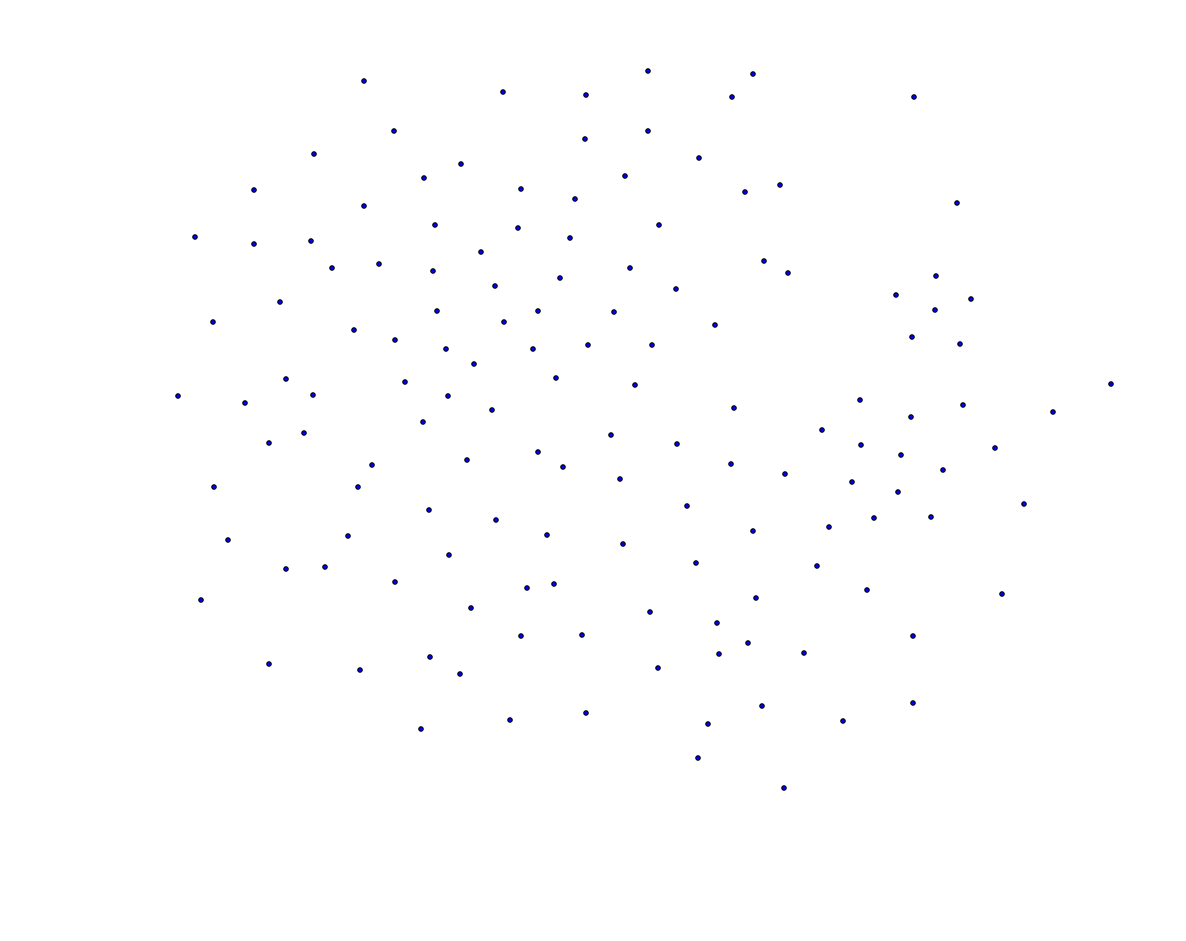

In [28]:
model = TSNE(n_components=2)
transformed_six_month = pd.DataFrame(model.fit_transform(df_normalized), columns=['X', 'Y'])
transformed_six_month.plot(kind='scatter', 
                 x='X', y='Y',
                figsize=(20,16))
matplotlib.pyplot.axis('off')

In [29]:
tfidftran = TfidfTransformer()
def_values = tfidftran.fit_transform(df_normalized)
df_clustering = df.copy()
df_deckids = df.copy()
df_deckids['index'] = [x for x in range(0, len(df_clustering))]
df_deckids = pd.DataFrame(df_deckids['index'])
df_deckids = df_deckids.merge(transformed_six_month, how='inner', left_on='index', right_index=True)
df_deckids

decks_to_send = deck_data.copy()
decks_to_send = decks_to_send.merge(df_deckids, how='inner', left_on='deck_id', right_index=True)

decks_to_send = decks_to_send[['X', 'Y', 'deck_id', 'name', 'created_at']]
decks_to_send
# decks_to_send.to_json('../../netrunner_website/data/noise-deck.json', orient='index')

cards = list(df_clustering.columns)
cards = [card for card in cards if card != 'grouping']
average_card_usage = {}
for card in cards:
    average = df_clustering[card].describe()['mean']
    if average > 0.0:
        average_card_usage[card] = average
        
average_card_usage

sorted_dict = sorted(average_card_usage.items(), key=operator.itemgetter(1), reverse=True)
sorted_dict

[('Hedge Fund', 2.711267605633803),
 ('Snare!', 2.6267605633802815),
 ('Fetal AI', 1.9788732394366197),
 ('House of Knives', 1.8098591549295775),
 ('Mushin No Shin', 1.6549295774647887),
 ('Jackson Howard', 1.6267605633802817),
 ('Project Junebug', 1.5633802816901408),
 ('Neural EMP', 1.380281690140845),
 ('The Future Perfect', 1.3450704225352113),
 ('Komainu', 1.0633802816901408),
 ('Psychic Field', 0.91549295774647887),
 ('Enigma', 0.88028169014084512),
 ('Neural Katana', 0.87323943661971826),
 ('Pup', 0.86619718309859151),
 ('PAD Campaign', 0.823943661971831),
 ('Nisei MK II', 0.80281690140845074),
 ('Ronin', 0.78169014084507038),
 ('Medical Research Fundraiser', 0.76760563380281688),
 ('Philotic Entanglement', 0.76056338028169013),
 ('Cerebral Overwriter', 0.73239436619718312),
 ('Chum', 0.71126760563380287),
 ('Medical Breakthrough', 0.65492957746478875),
 ('Cortex Lock', 0.62676056338028174),
 ('Gila Hands Arcology', 0.60563380281690138),
 ('Shock!', 0.56338028169014087),
 ('Wall

In [30]:
average_deck = []
card_counter = 0

for card in sorted_dict:
    card_count = round(card[1])
    card_counter += card_count
    if card_counter < 45:
        average_deck.append((card[0], card_count, card[1]))
    elif card_counter == 45:
        average_deck.append((card[0], card_count, card[1]))
        break
    else:
        amount_over = card_counter - 45
        card_count = card_count - amount_over
        average_deck.append((card[0], card_count, card[1]))
        pass

average_deck

[('Hedge Fund', 3.0, 2.711267605633803),
 ('Snare!', 3.0, 2.6267605633802815),
 ('Fetal AI', 2.0, 1.9788732394366197),
 ('House of Knives', 2.0, 1.8098591549295775),
 ('Mushin No Shin', 2.0, 1.6549295774647887),
 ('Jackson Howard', 2.0, 1.6267605633802817),
 ('Project Junebug', 2.0, 1.5633802816901408),
 ('Neural EMP', 1.0, 1.380281690140845),
 ('The Future Perfect', 1.0, 1.3450704225352113),
 ('Komainu', 1.0, 1.0633802816901408),
 ('Psychic Field', 1.0, 0.91549295774647887),
 ('Enigma', 1.0, 0.88028169014084512),
 ('Neural Katana', 1.0, 0.87323943661971826),
 ('Pup', 1.0, 0.86619718309859151),
 ('PAD Campaign', 1.0, 0.823943661971831),
 ('Nisei MK II', 1.0, 0.80281690140845074),
 ('Ronin', 1.0, 0.78169014084507038),
 ('Medical Research Fundraiser', 1.0, 0.76760563380281688),
 ('Philotic Entanglement', 1.0, 0.76056338028169013),
 ('Cerebral Overwriter', 1.0, 0.73239436619718312),
 ('Chum', 1.0, 0.71126760563380287),
 ('Medical Breakthrough', 1.0, 0.65492957746478875),
 ('Cortex Lock', 

In [32]:
mwl_corp_cards = {'Architect': {'faction': 'hb', 'inf': 2},
                   'AstroScript Pilot Program': {'faction': 'nbn', 'inf': 0},
                   'Eli 1.0': {'faction': 'hb', 'inf': 1},
                   'NAPD Contract': {'faction': 'neutral', 'inf': 0},
                    'SanSan City Grid': {'faction': 'nbn', 'inf': 3}
                   }

def test_mwl_corp_cards(faction):
    return_dict = {}
    for key, value in mwl_corp_cards.items():
        if value['faction'] == faction:
            return_dict[key] = 1
        else:
            return_dict[key] = (value['inf'] + 1) # really naive implementation
    return return_dict
            
print(test_mwl_corp_cards('jinteki'))

{'NAPD Contract': 1, 'Architect': 3, 'Eli 1.0': 2, 'AstroScript Pilot Program': 1, 'SanSan City Grid': 4}


In [33]:
# Testing out
import math

mwl_tracker = 0
mwl_cards = test_mwl_corp_cards('jinteki')
average_deck = []
card_counter = 0
for card in sorted_dict:
    card_count = math.ceil(card[1])
    card_counter += card_count
    if card[0] in mwl_cards.keys():
        mwl_tracker += card_count * mwl_cards[card[0]]
    print(card_counter, card[0], mwl_tracker)
    if card_counter < 45:
        average_deck.append((card[0], card_count, card[1]))
    elif card_counter == 45:
        average_deck.append((card[0], card_count, card[1]))
        break
    else:
        amount_over = card_counter - 45
        card_count = card_count - amount_over
        average_deck.append((card[0], card_count, card[1]))
        break

print(mwl_tracker)

3 Hedge Fund 0
6 Snare! 0
8 Fetal AI 0
10 House of Knives 0
12 Mushin No Shin 0
14 Jackson Howard 0
16 Project Junebug 0
18 Neural EMP 0
20 The Future Perfect 0
22 Komainu 0
23 Psychic Field 0
24 Enigma 0
25 Neural Katana 0
26 Pup 0
27 PAD Campaign 0
28 Nisei MK II 0
29 Ronin 0
30 Medical Research Fundraiser 0
31 Philotic Entanglement 0
32 Cerebral Overwriter 0
33 Chum 0
34 Medical Breakthrough 0
35 Cortex Lock 0
36 Gila Hands Arcology 0
37 Shock! 0
38 Wall of Static 0
39 Wall of Thorns 0
40 Data Mine 0
41 Trick of Light 0
42 Celebrity Gift 0
43 Private Security Force 0
44 Lockdown 0
45 Scorched Earth 0
0


In [34]:
average_deck

[('Hedge Fund', 3, 2.711267605633803),
 ('Snare!', 3, 2.6267605633802815),
 ('Fetal AI', 2, 1.9788732394366197),
 ('House of Knives', 2, 1.8098591549295775),
 ('Mushin No Shin', 2, 1.6549295774647887),
 ('Jackson Howard', 2, 1.6267605633802817),
 ('Project Junebug', 2, 1.5633802816901408),
 ('Neural EMP', 2, 1.380281690140845),
 ('The Future Perfect', 2, 1.3450704225352113),
 ('Komainu', 2, 1.0633802816901408),
 ('Psychic Field', 1, 0.91549295774647887),
 ('Enigma', 1, 0.88028169014084512),
 ('Neural Katana', 1, 0.87323943661971826),
 ('Pup', 1, 0.86619718309859151),
 ('PAD Campaign', 1, 0.823943661971831),
 ('Nisei MK II', 1, 0.80281690140845074),
 ('Ronin', 1, 0.78169014084507038),
 ('Medical Research Fundraiser', 1, 0.76760563380281688),
 ('Philotic Entanglement', 1, 0.76056338028169013),
 ('Cerebral Overwriter', 1, 0.73239436619718312),
 ('Chum', 1, 0.71126760563380287),
 ('Medical Breakthrough', 1, 0.65492957746478875),
 ('Cortex Lock', 1, 0.62676056338028174),
 ('Gila Hands Arcol

In [35]:
for card in average_deck:
    print(card[0], card[1])

Hedge Fund 3
Snare! 3
Fetal AI 2
House of Knives 2
Mushin No Shin 2
Jackson Howard 2
Project Junebug 2
Neural EMP 2
The Future Perfect 2
Komainu 2
Psychic Field 1
Enigma 1
Neural Katana 1
Pup 1
PAD Campaign 1
Nisei MK II 1
Ronin 1
Medical Research Fundraiser 1
Philotic Entanglement 1
Cerebral Overwriter 1
Chum 1
Medical Breakthrough 1
Cortex Lock 1
Gila Hands Arcology 1
Shock! 1
Wall of Static 1
Wall of Thorns 1
Data Mine 1
Trick of Light 1
Celebrity Gift 1
Private Security Force 1
Lockdown 1
Scorched Earth 1
